## **03. Modelos Estadísticos para Pronóstico de Heladas**

In [ ]:


# ## 1. Configuración inicial y carga de datos

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías específicas para modelos estadísticos
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
import pmdarima as pm  # Para auto_arima
# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, confusion_matrix

# Utilidades
import joblib
from tqdm import tqdm
import json
import os

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# %%
# Crear carpetas si no existen
os.makedirs('../results/predictions', exist_ok=True)
os.makedirs('../results/figures', exist_ok=True)
os.makedirs('../results/metrics', exist_ok=True)
os.makedirs('../models/trained', exist_ok=True)

# Cargar datos procesados
print("Cargando datos procesados...")
train_data = pd.read_csv('../data/processed/train_data.csv', parse_dates=['date'])
val_data = pd.read_csv('../data/processed/val_data.csv', parse_dates=['date'])
test_data = pd.read_csv('../data/processed/test_data.csv', parse_dates=['date'])

print(f"Train: {len(train_data):,} registros")
print(f"Val: {len(val_data):,} registros")
print(f"Test: {len(test_data):,} registros")

# Definir variables exógenas para SARIMAX
exog_vars = ['tmax', 'rh', 'pressure', 'temp_range', 'season_winter', 'season_autumn']

# %%
def evaluate_predictions(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    frost_true = (y_true <= 0).astype(int)
    frost_pred = (y_pred <= 0).astype(int)
    if frost_true.sum() > 0:
        precision = precision_score(frost_true, frost_pred, zero_division=0)
        recall = recall_score(frost_true, frost_pred, zero_division=0)
        f1 = f1_score(frost_true, frost_pred, zero_division=0)
        tn, fp, fn, tp = confusion_matrix(frost_true, frost_pred).ravel()
        tss = (tp/(tp+fn)) - (fp/(fp+tn)) if (tp+fn) > 0 and (fp+tn) > 0 else 0
    else:
        precision = recall = f1 = tss = 0
    metrics = {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tss': tss
    }
    return metrics

def plot_predictions_sample(y_true, y_pred, dates, model_name, sample_days=30):
    plt.figure(figsize=(15, 6))
    idx = np.random.randint(0, len(y_true) - sample_days)
    plt.plot(dates[idx:idx+sample_days], y_true[idx:idx+sample_days], 'b-', label='Real', linewidth=2)
    plt.plot(dates[idx:idx+sample_days], y_pred[idx:idx+sample_days], 'r--', label='Predicción', linewidth=2)
    plt.axhline(y=0, color='cyan', linestyle=':', alpha=0.7, label='Umbral helada')
    plt.xlabel('Fecha')
    plt.ylabel('Temperatura Mínima (°C)')
    plt.title(f'{model_name} - Muestra de Predicciones')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def save_predictions(predictions_dict, model_name):
    output_path = f'../results/predictions/pred_{model_name.lower().replace(" ", "_")}.csv'
    predictions_dict.to_csv(output_path, index=False)
    print(f"Predicciones guardadas en: {output_path}")

# %% [markdown]
# ## 3. Modelo 1: SARIMAX

# %%
print("="*70)
print("MODELO 1: SARIMAX")
print("="*70)

def train_sarimax_station(station_data, station_name, exog_vars=None):
    print(f"\nEntrenando SARIMAX para {station_name}...")
    train = station_data[station_data['date'] <= '2021-12-31'].copy()
    val = station_data[(station_data['date'] > '2021-12-31') & (station_data['date'] <= '2023-12-31')].copy()
    y_train = train.set_index('date')['tmin']
    y_val = val.set_index('date')['tmin']
    X_train = train.set_index('date')[exog_vars] if exog_vars else None
    X_val = val.set_index('date')[exog_vars] if exog_vars else None
    print("  Buscando parámetros óptimos con auto_arima...")
    auto_model = pm.auto_arima(
        y_train,
        exogenous=X_train,
        seasonal=True,
        m=365,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        max_p=3, max_q=3,
        max_P=2, max_Q=2,
        max_order=5,
        trace=False
    )
    print(f"  Mejores parámetros: {auto_model.order} x {auto_model.seasonal_order}")
    y_train_full = pd.concat([y_train, y_val])
    X_train_full = pd.concat([X_train, X_val]) if X_train is not None else None
    model = SARIMAX(
        y_train_full,
        exog=X_train_full,
        order=auto_model.order,
        seasonal_order=auto_model.seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)
    return model_fit, auto_model.order, auto_model.seasonal_order

sarimax_models = {}
sarimax_predictions = []

stations = train_data['station'].unique()
print(f"Entrenando modelos para {len(stations)} estaciones...")

for station in tqdm(stations):
    station_train = train_data[train_data['station'] == station]
    station_val = val_data[val_data['station'] == station]
    station_test = test_data[test_data['station'] == station]
    station_full = pd.concat([station_train, station_val])
    try:
        model_fit, order, seasonal_order = train_sarimax_station(
            station_full,
            station,
            exog_vars=exog_vars
        )
        X_test = station_test.set_index('date')[exog_vars]
        forecast = model_fit.forecast(steps=len(station_test), exog=X_test)
        pred_df = pd.DataFrame({
            'date': station_test['date'],
            'station': station,
            'tmin_true': station_test['tmin'].values,
            'tmin_pred': forecast.values
        })
        sarimax_predictions.append(pred_df)
        sarimax_models[station] = {
            'model': model_fit,
            'order': order,
            'seasonal_order': seasonal_order
        }
        metrics = evaluate_predictions(
            pred_df['tmin_true'],
            pred_df['tmin_pred'],
            f"SARIMAX-{station}"
        )
        print(f"  {station}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f}")
    except Exception as e:
        print(f"  Error en {station}: {str(e)}")

if sarimax_predictions:
    sarimax_all_predictions = pd.concat(sarimax_predictions, ignore_index=True)
    metrics_global = evaluate_predictions(
        sarimax_all_predictions['tmin_true'],
        sarimax_all_predictions['tmin_pred'],
        "SARIMAX-Global"
    )
    print(f"\nMétricas Globales SARIMAX:")
    print(f"RMSE: {metrics_global['rmse']:.3f}°C")
    print(f"MAE: {metrics_global['mae']:.3f}°C")
    print(f"R²: {metrics_global['r2']:.3f}")
    print(f"TSS: {metrics_global['tss']:.3f}")
    save_predictions(sarimax_all_predictions, 'sarimax')

# %% [markdown]
# ## 4. Modelo 2: Holt-Winters

# %%
print("\n" + "="*70)
print("MODELO 2: HOLT-WINTERS")
print("="*70)

def train_holtwinters_station(station_data, station_name):
    print(f"\nEntrenando Holt-Winters para {station_name}...")
    train = station_data[station_data['date'] <= '2023-12-31'].copy()
    train = train.set_index('date')['tmin']
    train = train.asfreq('D', method='ffill')
    model = ExponentialSmoothing(
        train,
        seasonal_periods=365,
        trend='add',
        seasonal='mul',
        damped_trend=True
    )
    model_fit = model.fit(optimized=True)
    return model_fit

hw_models = {}
hw_predictions = []

for station in tqdm(stations):
    station_full = pd.concat([
        train_data[train_data['station'] == station],
        val_data[val_data['station'] == station]
    ])
    station_test = test_data[test_data['station'] == station]
    try:
        model_fit = train_holtwinters_station(station_full, station)
        forecast = model_fit.forecast(steps=len(station_test))
        pred_df = pd.DataFrame({
            'date': station_test['date'],
            'station': station,
            'tmin_true': station_test['tmin'].values,
            'tmin_pred': forecast.values
        })
        hw_predictions.append(pred_df)
        hw_models[station] = model_fit
        metrics = evaluate_predictions(
            pred_df['tmin_true'],
            pred_df['tmin_pred'],
            f"HW-{station}"
        )
        print(f"  {station}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f}")
    except Exception as e:
        print(f"  Error en {station}: {str(e)}")

if hw_predictions:
    hw_all_predictions = pd.concat(hw_predictions, ignore_index=True)
    metrics_global = evaluate_predictions(
        hw_all_predictions['tmin_true'],
        hw_all_predictions['tmin_pred'],
        "Holt-Winters-Global"
    )
    print(f"\nMétricas Globales Holt-Winters:")
    print(f"RMSE: {metrics_global['rmse']:.3f}°C")
    print(f"MAE: {metrics_global['mae']:.3f}°C")
    print(f"R²: {metrics_global['r2']:.3f}")
    print(f"TSS: {metrics_global['tss']:.3f}")
    save_predictions(hw_all_predictions, 'holtwinters')

# %% [markdown]
# ## 5. Modelo 3: Prophet

# %%
print("\n" + "="*70)
print("MODELO 3: PROPHET")
print("="*70)

def train_prophet_station(station_data, station_name):
    print(f"\nEntrenando Prophet para {station_name}...")
    train = station_data[station_data['date'] <= '2023-12-31'].copy()
    prophet_data = pd.DataFrame({
        'ds': train['date'],
        'y': train['tmin']
    })
    for var in ['tmax', 'rh', 'pressure']:
        if var in train.columns:
            prophet_data[var] = train[var].values
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.05,
        interval_width=0.95
    )
    for var in ['tmax', 'rh', 'pressure']:
        if var in prophet_data.columns:
            model.add_regressor(var)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(prophet_data)
    return model

prophet_models = {}
prophet_predictions = []

for station in tqdm(stations):
    station_full = pd.concat([
        train_data[train_data['station'] == station],
        val_data[val_data['station'] == station]
    ])
    station_test = test_data[test_data['station'] == station].copy()
    try:
        model = train_prophet_station(station_full, station)
        future = pd.DataFrame({
            'ds': station_test['date']
        })
        for var in ['tmax', 'rh', 'pressure']:
            if var in station_test.columns:
                future[var] = station_test[var].values
        forecast = model.predict(future)
        pred_df = pd.DataFrame({
            'date': station_test['date'],
            'station': station,
            'tmin_true': station_test['tmin'].values,
            'tmin_pred': forecast['yhat'].values
        })
        prophet_predictions.append(pred_df)
        prophet_models[station] = model
        metrics = evaluate_predictions(
            pred_df['tmin_true'],
            pred_df['tmin_pred'],
            f"Prophet-{station}"
        )
        print(f"  {station}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f}")
    except Exception as e:
        print(f"  Error en {station}: {str(e)}")

if prophet_predictions:
    prophet_all_predictions = pd.concat(prophet_predictions, ignore_index=True)
    metrics_global = evaluate_predictions(
        prophet_all_predictions['tmin_true'],
        prophet_all_predictions['tmin_pred'],
        "Prophet-Global"
    )
    print(f"\nMétricas Globales Prophet:")
    print(f"RMSE: {metrics_global['rmse']:.3f}°C")
    print(f"MAE: {metrics_global['mae']:.3f}°C")
    print(f"R²: {metrics_global['r2']:.3f}")
    print(f"TSS: {metrics_global['tss']:.3f}")
    save_predictions(prophet_all_predictions, 'prophet')

# %% [markdown]
# ## 6. Modelo 4: STL + ARIMA

# %%
print("\n" + "="*70)
print("MODELO 4: STL + ARIMA")
print("="*70)

def train_stl_arima_station(station_data, station_name):
    print(f"\nEntrenando STL+ARIMA para {station_name}...")
    train = station_data[station_data['date'] <= '2023-12-31'].copy()
    train = train.drop_duplicates(subset='date', keep='first')  # LIMPIEZA DE DUPLICADOS
    train_ts = train.set_index('date')['tmin']
    train_ts = train_ts.asfreq('D', method='ffill')
    train_ts = train_ts[~train_ts.index.duplicated(keep='first')]  # Por si acaso

    stl = STL(train_ts, seasonal=13, trend=365)
    stl_result = stl.fit()
    residuals = stl_result.resid
    print("  Ajustando ARIMA a residuos...")
    arima_model = pm.auto_arima(
        residuals,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        max_p=5, max_q=5,
        trace=False
    )
    print(f"  ARIMA order: {arima_model.order}")
    return stl_result, arima_model

stl_models = {}
stl_predictions = []

for station in tqdm(stations):
    station_full = pd.concat([
        train_data[train_data['station'] == station],
        val_data[val_data['station'] == station]
    ])
    station_test = test_data[test_data['station'] == station].copy()
    try:
        stl_result, arima_model = train_stl_arima_station(station_full, station)
        trend = stl_result.trend
        trend_last = trend.iloc[-365:].values
        trend_mean_change = np.mean(np.diff(trend_last))
        trend_forecast = trend.iloc[-1] + trend_mean_change * np.arange(1, len(station_test) + 1)
        seasonal = stl_result.seasonal
        seasonal_cycle = seasonal.iloc[-365:].values
        seasonal_forecast = np.tile(seasonal_cycle, (len(station_test) // 365 + 1))[:len(station_test)]
        residual_forecast = arima_model.predict(n_periods=len(station_test))
        forecast = trend_forecast + seasonal_forecast + residual_forecast
        pred_df = pd.DataFrame({
            'date': station_test['date'],
            'station': station,
            'tmin_true': station_test['tmin'].values,
            'tmin_pred': forecast
        })
        stl_predictions.append(pred_df)
        stl_models[station] = {
            'stl': stl_result,
            'arima': arima_model
        }
        metrics = evaluate_predictions(
            pred_df['tmin_true'],
            pred_df['tmin_pred'],
            f"STL-ARIMA-{station}"
        )
        print(f"  {station}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f}")
    except Exception as e:
        print(f"  Error en {station}: {str(e)}")

if stl_predictions:
    stl_all_predictions = pd.concat(stl_predictions, ignore_index=True)
    metrics_global = evaluate_predictions(
        stl_all_predictions['tmin_true'],
        stl_all_predictions['tmin_pred'],
        "STL-ARIMA-Global"
    )
    print(f"\nMétricas Globales STL+ARIMA:")
    print(f"RMSE: {metrics_global['rmse']:.3f}°C")
    print(f"MAE: {metrics_global['mae']:.3f}°C")
    print(f"R²: {metrics_global['r2']:.3f}")
    print(f"TSS: {metrics_global['tss']:.3f}")
    save_predictions(stl_all_predictions, 'stl_arima')

# %% [markdown]
# ## 7. Comparación y resumen

# %%
all_metrics = []
if 'sarimax_all_predictions' in locals():
    metrics = evaluate_predictions(
        sarimax_all_predictions['tmin_true'],
        sarimax_all_predictions['tmin_pred'],
        "SARIMAX"
    )
    all_metrics.append(metrics)
if 'hw_all_predictions' in locals():
    metrics = evaluate_predictions(
        hw_all_predictions['tmin_true'],
        hw_all_predictions['tmin_pred'],
        "Holt-Winters"
    )
    all_metrics.append(metrics)
if 'prophet_all_predictions' in locals():
    metrics = evaluate_predictions(
        prophet_all_predictions['tmin_true'],
        prophet_all_predictions['tmin_pred'],
        "Prophet"
    )
    all_metrics.append(metrics)
if 'stl_all_predictions' in locals():
    metrics = evaluate_predictions(
        stl_all_predictions['tmin_true'],
        stl_all_predictions['tmin_pred'],
        "STL+ARIMA"
    )
    all_metrics.append(metrics)
metrics_df = pd.DataFrame(all_metrics)
metrics_df = metrics_df.set_index('model')

print("\n" + "="*70)
print("COMPARACIÓN DE MODELOS ESTADÍSTICOS")
print("="*70)
print(metrics_df.round(3))

# Guardar resumen de modelos
model_summary = {
    'statistical_models': {
        'sarimax': {
            'description': 'Seasonal ARIMA with exogenous variables',
            'stations_trained': len(sarimax_models) if 'sarimax_models' in locals() else 0,
            'metrics': metrics_df.loc['SARIMAX'].to_dict() if 'SARIMAX' in metrics_df.index else {}
        },
        'holt_winters': {
            'description': 'Triple exponential smoothing',
            'stations_trained': len(hw_models) if 'hw_models' in locals() else 0,
            'metrics': metrics_df.loc['Holt-Winters'].to_dict() if 'Holt-Winters' in metrics_df.index else {}
        },
        'prophet': {
            'description': 'Facebook Prophet with additional regressors',
            'stations_trained': len(prophet_models) if 'prophet_models' in locals() else 0,
            'metrics': metrics_df.loc['Prophet'].to_dict() if 'Prophet' in metrics_df.index else {}
        },
        'stl_arima': {
            'description': 'STL decomposition + ARIMA on residuals',
            'stations_trained': len(stl_models) if 'stl_models' in locals() else 0,
            'metrics': metrics_df.loc['STL+ARIMA'].to_dict() if 'STL+ARIMA' in metrics_df.index else {}
        }
    },
    'best_model': metrics_df['rmse'].idxmin() if len(metrics_df) > 0 else 'N/A',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open('../results/metrics/statistical_models_summary.json', 'w') as f:
    json.dump(model_summary, f, indent=4, default=str)
print("\n" + "="*70)
print("RESUMEN FINAL")
print("="*70)
print(f"Mejor modelo estadístico: {model_summary['best_model']}")
if len(metrics_df) > 0:
    best_rmse = metrics_df['rmse'].min()
    print(f"RMSE: {best_rmse:.3f}°C")
    print(f"Mejora vs baseline: {((3.5 - best_rmse) / 3.5 * 100):.1f}%")  # Baseline RMSE 3.5

# Guardar modelos entrenados (solo un ejemplo por tipo)
print("\nGuardando modelos...")
joblib.dump(
    {
        'sarimax': list(sarimax_models.values())[0] if sarimax_models else None,
        'prophet': list(prophet_models.values())[0] if prophet_models else None,
        'summary': model_summary
    },
    '../models/trained/statistical_models_sample.pkl'
)

print("\nProceso completado. Modelos y predicciones guardados.")



Cargando datos procesados...
Train: 34,248 registros
Val: 3,120 registros
Test: 2,334 registros
MODELO 1: SARIMAX
Entrenando modelos para 1 estaciones...


100%|██████████| 1/1 [00:00<00:00, 17.87it/s]



Entrenando SARIMAX para POWER...
  Error en POWER: "['season_winter'] not in index"

MODELO 2: HOLT-WINTERS


100%|██████████| 1/1 [00:00<00:00, 24.33it/s]



Entrenando Holt-Winters para POWER...
  Error en POWER: cannot reindex on an axis with duplicate labels

MODELO 3: PROPHET


  0%|          | 0/1 [00:00<?, ?it/s]


Entrenando Prophet para POWER...


22:02:16 - cmdstanpy - INFO - Chain [1] start processing
22:02:30 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:16<00:00, 16.43s/it]


  POWER: RMSE=2.096, MAE=1.700

Métricas Globales Prophet:
RMSE: 2.096°C
MAE: 1.700°C
R²: 0.574
TSS: 0.582
Predicciones guardadas en: ../results/predictions/pred_prophet.csv

MODELO 4: STL + ARIMA


  0%|          | 0/1 [00:00<?, ?it/s]


Entrenando STL+ARIMA para POWER...


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

  Ajustando ARIMA a residuos...
  Error en POWER: name 'pm' is not defined

COMPARACIÓN DE MODELOS ESTADÍSTICOS
          rmse  mae     r2  precision  recall    f1    tss
model                                                     
Prophet  2.096  1.7  0.574      0.592   0.696  0.64  0.582

RESUMEN FINAL
Mejor modelo estadístico: Prophet
RMSE: 2.096°C
Mejora vs baseline: 40.1%

Guardando modelos...

Proceso completado. Modelos y predicciones guardados.


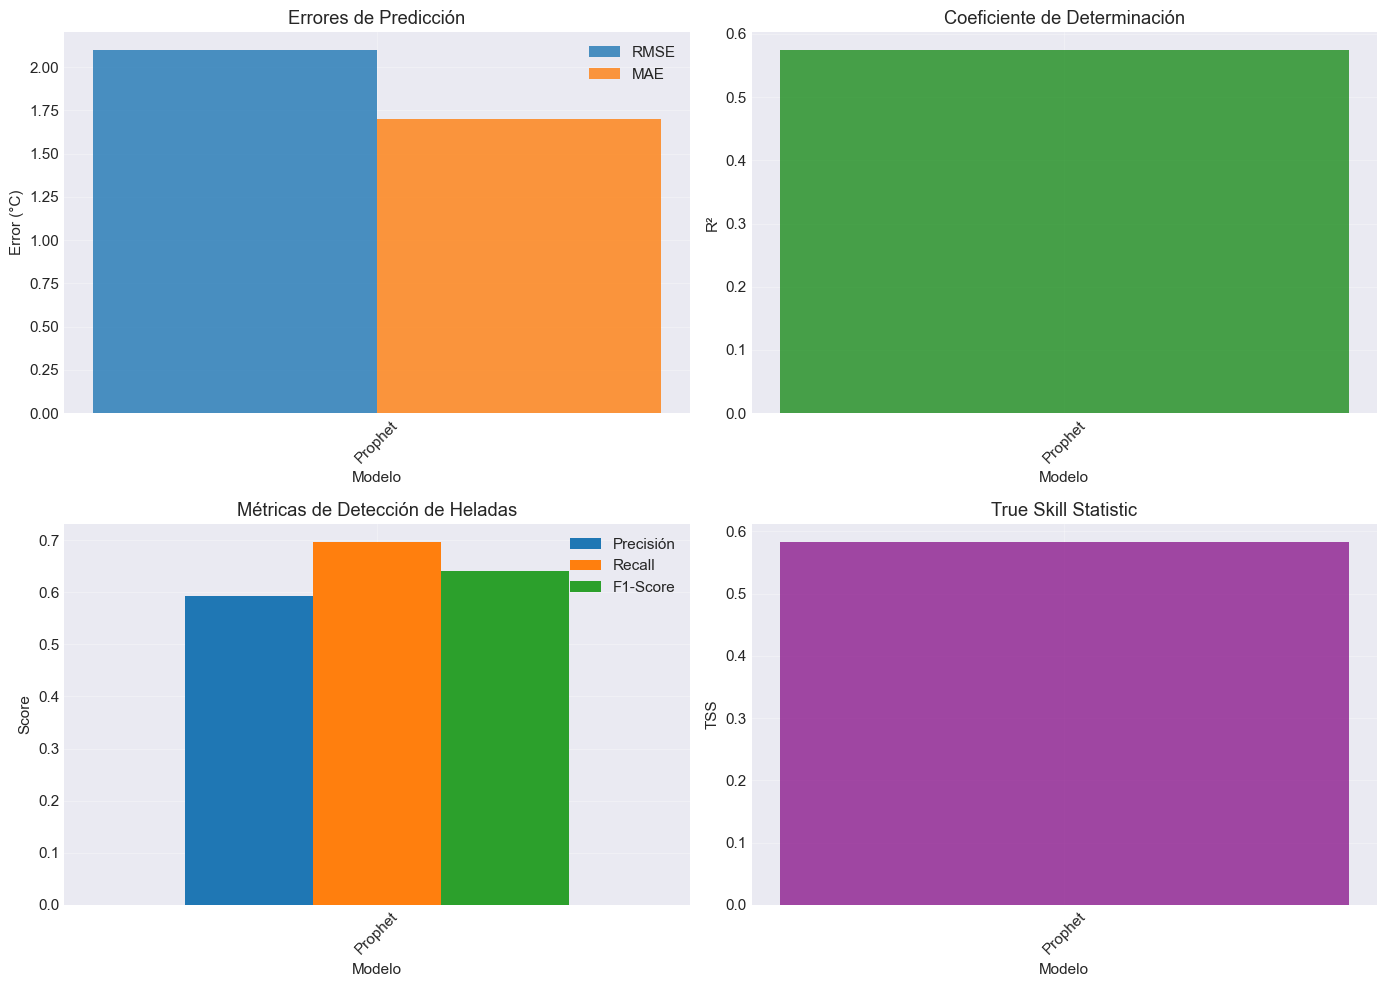

In [22]:
# %% [markdown]
# ## Visualización comparativa de métricas

# %%
import matplotlib.pyplot as plt
import numpy as np

# Si metrics_df no existe, asegúrate de crearlo antes con los modelos que tienes entrenados
if 'metrics_df' in locals() and not metrics_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Errores RMSE y MAE
    ax1 = axes[0, 0]
    x = np.arange(len(metrics_df))
    width = 0.35
    ax1.bar(x - width/2, metrics_df['rmse'], width, label='RMSE', alpha=0.8)
    ax1.bar(x + width/2, metrics_df['mae'], width, label='MAE', alpha=0.8)
    ax1.set_xlabel('Modelo')
    ax1.set_ylabel('Error (°C)')
    ax1.set_title('Errores de Predicción')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics_df.index, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. R²
    ax2 = axes[0, 1]
    ax2.bar(metrics_df.index, metrics_df['r2'], color='green', alpha=0.7)
    ax2.set_xlabel('Modelo')
    ax2.set_ylabel('R²')
    ax2.set_title('Coeficiente de Determinación')
    ax2.set_xticklabels(metrics_df.index, rotation=45)
    ax2.grid(True, alpha=0.3)

    # 3. Métricas de clasificación: Precision, Recall y F1
    ax3 = axes[1, 0]
    metrics_clf = metrics_df[['precision', 'recall', 'f1']]
    metrics_clf.plot(kind='bar', ax=ax3, width=0.8)
    ax3.set_xlabel('Modelo')
    ax3.set_ylabel('Score')
    ax3.set_title('Métricas de Detección de Heladas')
    ax3.legend(['Precisión', 'Recall', 'F1-Score'])
    ax3.set_xticklabels(metrics_df.index, rotation=45)
    ax3.grid(True, alpha=0.3)

    # 4. TSS
    ax4 = axes[1, 1]
    ax4.bar(metrics_df.index, metrics_df['tss'], color='purple', alpha=0.7)
    ax4.set_xlabel('Modelo')
    ax4.set_ylabel('TSS')
    ax4.set_title('True Skill Statistic')
    ax4.set_xticklabels(metrics_df.index, rotation=45)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../results/figures/statistical_models_comparison.png', dpi=300)
    plt.show()
else:
    print("No se encontraron métricas para graficar. Entrena y evalúa modelos primero.")
